In [30]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
  
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-dataset/lingSpam.csv
/kaggle/input/email-spam-dataset/enronSpamSubset.csv
/kaggle/input/email-spam-dataset/completeSpamAssassin.csv


In [31]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations
pd.set_option('display.max_columns', None) # code to display all columns

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for text processing and handling text data
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from collections import Counter

# all the required models 
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# for model evaluation
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score


**BASIC DATA ANALYSIS**

In [32]:
# loading the dataset
df = pd.read_csv('/kaggle/input/email-spam-dataset/completeSpamAssassin.csv')
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [33]:
#How big is data?
df.shape

(6046, 3)

In [34]:
# What is the data type of cols?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


**DATA CLEANING**

In [35]:
# Are there any missing values?
df.isnull().sum()

Unnamed: 0    0
Body          1
Label         0
dtype: int64

In [36]:
# Are there any duplicate values?
df.duplicated().sum()

0

In [37]:
# dropping null values
df.dropna(inplace=True)

**Simple EDA**

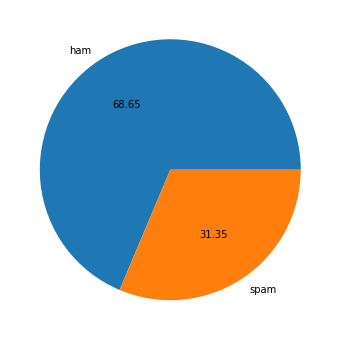

In [38]:
# Let's see the distribution of target variable
plt.figure(figsize=(12,6))
plt.pie(df['Label'].value_counts(), labels=['ham','spam'], autopct='%0.2f')
plt.show()

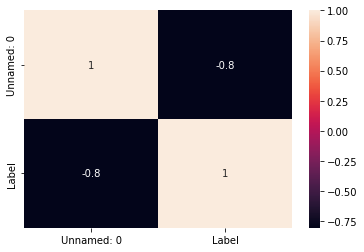

In [39]:
sns.heatmap(df.corr(), annot=True)
plt.show()

**TEXT PREPROCESSING**

In [40]:
def text_preprocessing(text):
    # convert  text to lowecase
    text = text.lower()
    
    # creating list of words in email
    text = nltk.word_tokenize(text)
    
    # removing special charecters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    # copying processed text to text and clearing y to store next steps output
    text = y[:]
    y.clear()
    
    # removing stopwords and punctuation marks
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    # stemming 
    stemmer = SnowballStemmer('english')
    for i in text:
        y.append(stemmer.stem(i))
        
    return " ".join(y)

In [41]:
# applying function to text
df['clean_text'] = df['Body'].apply(text_preprocessing)

In [42]:
# creating list of all the words in processed spam emails
spam_corpus = []
for mail in df[df['Label'] == 1]['clean_text'].tolist():
    for word in mail.split():
        spam_corpus.append(word)

# number of words in all spam mails
len(spam_corpus)

276880

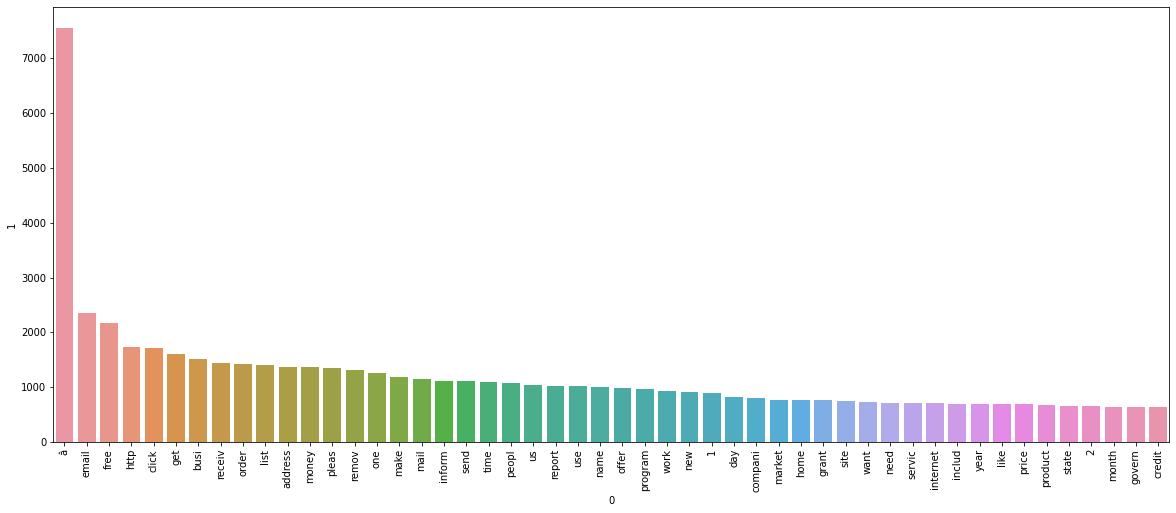

In [43]:
# top 50 most occuring words in spam mails
plt.figure(figsize=(20,8))
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(50))[0],pd.DataFrame(Counter(spam_corpus).most_common(50))[1])
plt.xticks(rotation='vertical')
plt.show()

In [44]:
# creating list of all the words in processed ham emails
ham_corpus = []
for mail in df[df['Label'] == 0]['clean_text'].tolist():
    for word in mail.split():
        ham_corpus.append(word)

# number of words in all ham mails
len(ham_corpus)

547660

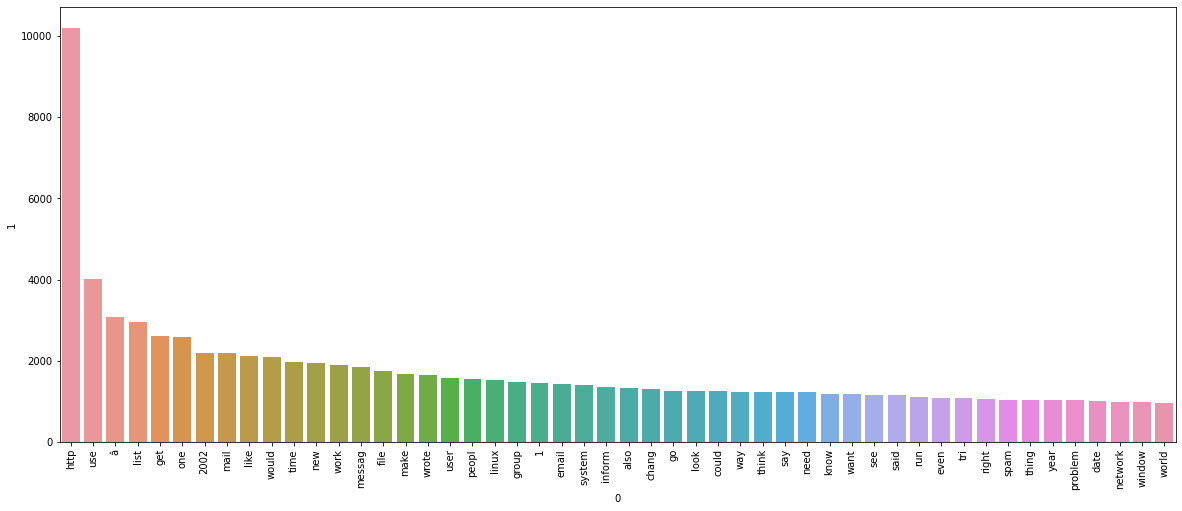

In [45]:
# top 50 most occuring words in ham mails
plt.figure(figsize=(20,8))
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(50))[0],pd.DataFrame(Counter(ham_corpus).most_common(50))[1])
plt.xticks(rotation='vertical')
plt.show()

**SPLIT [TRAIN+TEST]**

In [46]:
#Changing text data in to numbers.

# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(max_features=17000)

# Setting up features and target as x and y
x = tfidf.fit_transform(df['clean_text']).toarray()
y = df['Label'].values

In [47]:
# Splitting the testing and training sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

**MODELS**

In [48]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')


In [49]:
classifiers = {
    'GaussianNB' : gnb,
    'MultinomialNB' : mnb,
    'BernoulliNB' : bnb,
    'SVC' : svc,
    'KNeighbors' : knc, 
    'DecisionTree': dtc, 
    'LogisticRegression': lrc, 
}

In [50]:
# creating a function to train list of algorithms and give accuracy , precision score
def train_classifier(classifiers,x_train,y_train,x_test,y_test):
    
    classifiers.fit(x_train,y_train)
    
    y_pred = classifiers.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [51]:
# storing accuracy and precision in list
accuracy_scores = []
precision_scores = []

# training all the models on training data
for name,classifiers in classifiers.items():
    
    current_accuracy,current_precision = train_classifier(classifiers, x_train,y_train,x_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision,'\n')
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  GaussianNB
Accuracy -  0.9098428453267163
Precision -  0.8388746803069054 

For  MultinomialNB
Accuracy -  0.9371381306865177
Precision -  0.8983957219251337 

For  BernoulliNB
Accuracy -  0.9421009098428453
Precision -  0.9810126582278481 

For  SVC
Accuracy -  0.9578163771712159
Precision -  0.9007444168734491 

For  KNeighbors
Accuracy -  0.3945409429280397
Precision -  0.33815551537070526 

For  DecisionTree
Accuracy -  0.8866832092638545
Precision -  0.7984886649874056 

For  LogisticRegression
Accuracy -  0.9338296112489661
Precision -  0.8828125 

